In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

## 1. Proposed algorithm

The essence of the algorithm is to replace the price of a cryptocurrency with one of the words (top, bot, const), depending on the position relative to the average price. Thus, the time series of prices will be converted into tokens, ready for LLM training. A detailed description of the algorithm is given below:

In [3]:
# timeframe - 1h
df = pd.read_csv("BTCUSDT-1h.csv")

In [4]:
df.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,171,35.160503
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,102,21.448071
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,36,4.802861
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,25,2.602292
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,28,0.814655


In [5]:
# Let's define a random series of opening prices for cryptocurrencies
klines_open_price = df["open"].to_numpy()

# Define two variables
DATA_LEN = 40
TAIL_LEN = 3
EPSILON = 50

# Take the random sample of time series
i = random.randint(0, len(klines_open_price)-(DATA_LEN + TAIL_LEN))
sample = klines_open_price[i: i + DATA_LEN + TAIL_LEN]
print("Sample length:", len(sample))

Sample length: 43


In [6]:
# split sample into data and tail
data, tail = sample[:DATA_LEN], sample[-TAIL_LEN:]
print("Data length:", len(data))
print("Tail length:", len(tail))

# Finding the mean value of data
mean = np.mean(data)

Data length: 40
Tail length: 3


In [7]:
tokens = []

for price in sample:
    if np.abs(price - mean) < EPSILON:
        tokens.append("const")
    elif price < mean:
        tokens.append("bot")
    elif price > mean:
        tokens.append("top")

tokens_x = tokens[:DATA_LEN]
tokens_y = tokens[-TAIL_LEN:]

print("Tokens X length:", len(tokens_x))
print("Tokens Y length:", len(tokens_y), '\n')

print("Tokens X:", tokens_x, '\n')
print("Tokens Y:", tokens_y)

Tokens X length: 40
Tokens Y length: 3 

Tokens X: ['top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot', 'bot'] 

Tokens Y: ['bot', 'bot', 'bot']


In [8]:
def draw_price_transform(sample, tokens, mean):

    replacements = {"bot": 0, "const": 1, "top": 2}
    replacer = replacements.get  # For faster gets.

    mask = [replacements[token] for token in tokens]
    
    colors = [(255,0,0),  (0,255,0)]
    gradient = mcolors.LinearSegmentedColormap.from_list('custom_gradient', colors)
    gradient_list = np.array(mask).reshape(1,-1)
    
    fig, axs = plt.subplots(1, figsize=(10,5), frameon=False)
    
    axs.set_ylim(sample.min()-100, sample.max()+100)
    axs.plot(sample, label='Original data')
    axs.plot([DATA_LEN, DATA_LEN], [sample.min(), sample.max()], '--', label='Line of train and test split')
    axs.plot([0, DATA_LEN + TAIL_LEN], [mean, mean], c='r', label='Mean value of train part')

    
    axs.imshow(gradient_list, aspect='auto', cmap=gradient, extent=(0, len(mask), axs.get_ylim()[0], axs.get_ylim()[1]), alpha=0.25)
    plt.legend()
    plt.show()

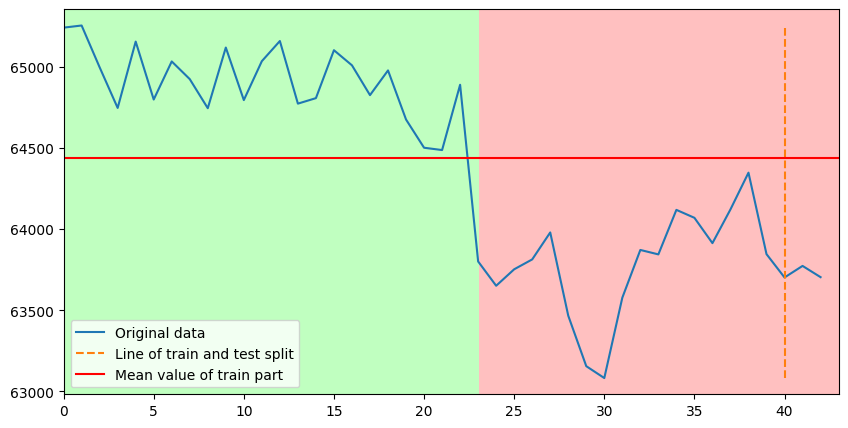

In [9]:
draw_price_transform(sample, tokens, mean)

1. **Green color** - the price is above average
2. **Red color** - the price is below average
3. **Yellow color** - price in the vicinity of the average

# 2. Practical part

## 2.1 Load data

In [10]:
# timeframe - 1h
df = pd.read_csv("BTCUSDT-1h.csv")

In [11]:
# Data illustration
df.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,171,35.160503
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,102,21.448071
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,36,4.802861
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,25,2.602292
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,28,0.814655


In [114]:
# Split for train and test part
X_train = df[:int(df.shape[0]*0.75)]
X_test  = df[int(df.shape[0]*0.75):].reset_index(drop=True)
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

X_train shape: (41940, 8)
X_test  shape: (13981, 8)


## 2.2 klines transformation

In [16]:
# FUNCTION for data transformation according to the proposed algorithm

def transform_klines(klines, data_len, tail_len, epsilon):

    # split into data and tail
    data, tail = klines[:data_len], klines[-tail_len:]
    # find mean value
    mean = np.mean(data)

    # Run through the data, collecting data on the price position relative to the average
    x = []
    for point in data:
        if np.abs(mean - point) < epsilon:
            x.append('const')
        elif point < mean:
            x.append('bot')
        elif point > mean:
            x.append('top')

    # Run along the tail, collect data on the price position relative to the average
    y = []
    for point in tail:
        if np.abs(mean - point) < epsilon:
            y.append('const')
        elif point < mean:
            y.append('bot')
        elif point > mean:
            y.append('top')

    # Transforms arrays into strings
    x = "<sos> " + " ".join(x) + " <eos>"
    y = "<sos> " + " ".join(y) + " <eos>"

    return x, y, mean

# ФУНКЦИЯ для ТОКЕНИЗАЦИИ текста
def embed_string(string):
    emb_string = []
    for s in string.split(' '):
        emb_string.append(VOCABULARY[s])
    return emb_string

## 2.3 Init vocabulary for LLM

In [104]:
# Introducing a DICTIONARY for the model (word - number)
VOCABULARY = {
    '<sos>': 0,
    '<eos>': 1,
    'bot': 2,
    'top': 3,
    'const': 4
}

VOCABULARY_DECODE = {v: k for k, v in VOCABULARY.items()}

## 2.4 Creating Dataset for LLM

In [105]:
class MyDataset(Dataset):
    def __init__(self, df, data_len, tail_len, lvl, step=10):
        self.X = []
        self.Y = []
        self.KLINES = []
        seq_len = data_len + tail_len
        
        for i in range(0, df.shape[0] - seq_len - 1, step):
            kline_time_series = df['open'][i:i+seq_len].to_numpy()
            self.KLINES.append(kline_time_series)
            x, y, _ = transform_klines(kline_time_series, data_len, tail_len, lvl)
            
            if x is not None:
                x = embed_string(x)
                y = embed_string(y)
    
                self.X.append(x)
                self.Y.append(y)
        
    def __getitem__(self, idx):
        return torch.LongTensor(self.X[idx]), torch.LongTensor(self.Y[idx]), self.KLINES[idx]
        
    def __len__(self):
        return len(self.X)

def get_collate_fn():
    def collate_fn(batch):
        
        #nn.utils.rnn.pad_sequence(batch, padding_value=pad_index)
        input = [example[0] for example in batch]
        target = [example[1] for example in batch]
        klines = [example[2] for example in batch]
        # input = nn.utils.rnn.pad_sequence(input, padding_value=pad_index)
        # target = nn.utils.rnn.pad_sequence(target, padding_value=pad_index)
        
        return torch.LongTensor(input), torch.LongTensor(target), klines

    return collate_fn

In [107]:
# CREATING datasets for training and testing the model
DATA_LEN = 40
TAIL_LEN = 3
EPSILON = 10
STEP = 1

# PyTorch Datasets
train_dataset = MyDataset(X_train, DATA_LEN, TAIL_LEN, EPSILON, step=STEP)
test_dataset = MyDataset(X_test, DATA_LEN, TAIL_LEN, EPSILON, step=STEP)

print("Train dataset length:", len(train_dataset))
print("Test  dataset length:", len(test_dataset))

# PyTorch DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=get_collate_fn())
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=16, collate_fn=get_collate_fn())

Train dataset length: 41896
Test  dataset length: 13937


In [108]:
# An example of what the data for the model looks like
# As you can see, we have replaced the WORDS with their INDEXES
train_dataset[104][:2]

(tensor([0, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]),
 tensor([0, 3, 3, 3, 1]))

## 2.5 LLM architecture

In [109]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)#,  padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [110]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.9):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [51]:
# An LLM of the form seq2seq is used for prediction
# works on the principle of sequence->sequence

# Such models were the first translators of foreign languages,
# that is, they do a great job GENERATING string sequences

# torch.nn.Embeddings - params
INPUT_DIM  = len(VOCABULARY.keys()) # = 5
OUTPUT_DIM = len(VOCABULARY.keys()) # = 5
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16

# torch.nn.LSTM - params
HID_DIM = 128
N_LAYERS = 2

# torch.nn.Dropout - params
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Creating Encoder and Decoder
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# Creating Seq2Seq model
device = "cpu"
model = Seq2Seq(enc, dec, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 414,501 trainable parameters


In [53]:
# Initializing weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)
print()

## 2.6 Train

In [55]:
# Creating an optimizer and an loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, weight=torch.tensor([0.1, 0.1, 1, 1, 1]))

In [62]:
# Training the model
model.train()
losses = []
for ep in range(1):
    print("EPOCH ------------------------------- ", ep)
    for i, batch in enumerate(train_dataloader):
        
        src, trg, _ = batch
        optimizer.zero_grad()
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)    
        loss = criterion(output, trg)
        
        loss.backward()
        
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0:
            print(loss)
            torch.save(model.state_dict(), "seq2seq.pth")

EPOCH -------------------------------  0
tensor(1.5945, grad_fn=<NllLossBackward0>)
tensor(0.9591, grad_fn=<NllLossBackward0>)
tensor(0.8972, grad_fn=<NllLossBackward0>)
tensor(0.9526, grad_fn=<NllLossBackward0>)
tensor(0.5179, grad_fn=<NllLossBackward0>)
tensor(0.5307, grad_fn=<NllLossBackward0>)
tensor(0.4027, grad_fn=<NllLossBackward0>)
tensor(0.4316, grad_fn=<NllLossBackward0>)
tensor(0.7691, grad_fn=<NllLossBackward0>)
tensor(0.6960, grad_fn=<NllLossBackward0>)
tensor(0.4145, grad_fn=<NllLossBackward0>)
tensor(0.3709, grad_fn=<NllLossBackward0>)
tensor(0.4747, grad_fn=<NllLossBackward0>)
tensor(0.2621, grad_fn=<NllLossBackward0>)
tensor(0.6786, grad_fn=<NllLossBackward0>)
tensor(0.3841, grad_fn=<NllLossBackward0>)
tensor(0.4576, grad_fn=<NllLossBackward0>)
tensor(0.3595, grad_fn=<NllLossBackward0>)
tensor(0.2839, grad_fn=<NllLossBackward0>)
tensor(0.3528, grad_fn=<NllLossBackward0>)
tensor(0.1381, grad_fn=<NllLossBackward0>)
tensor(0.3519, grad_fn=<NllLossBackward0>)
tensor(0.2875

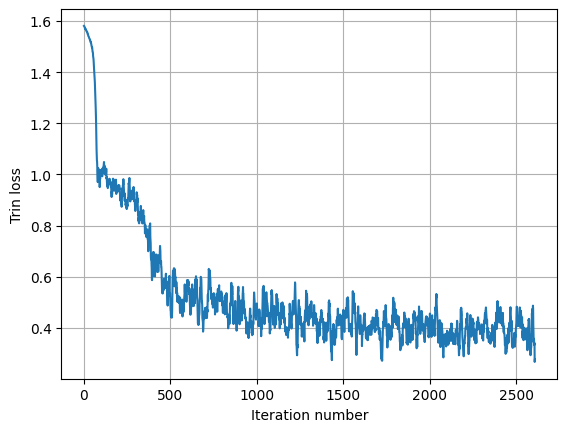

In [63]:
# plot the filtering LOSS
means = []
for i in range(len(losses)-10):
    means.append(np.mean(losses[i: i+10]))
plt.plot(means, label="Train loss")
plt.grid()
plt.xlabel("Iteration number")
plt.ylabel("Trin loss")
plt.show()

## 2.7 Test

In [101]:
n_correct = 0
n_total = 0
for batch in tqdm(test_dataloader):
    src, trg, _ = batch
    output = model(src, trg, 0)
    correct_or_not = (output.argmax(-1) == trg)

    n_correct += correct_or_not.sum()
    n_total += torch.numel(correct_or_not)
 
print(f"Accuracy: {n_correct / n_total * 100:.2f} %")

100%|███████████████████████████████████████████████████████████████████████████████| 872/872 [00:07<00:00, 122.27it/s]

Accuracy: 90.65 %


## 2.8 Test and plot

TARGET: [3, 3, 3]
TARGET as string: ['top', 'top', 'top']
-------------
PRED: [3 3 3]
PRED as string: ['top', 'top', 'top']




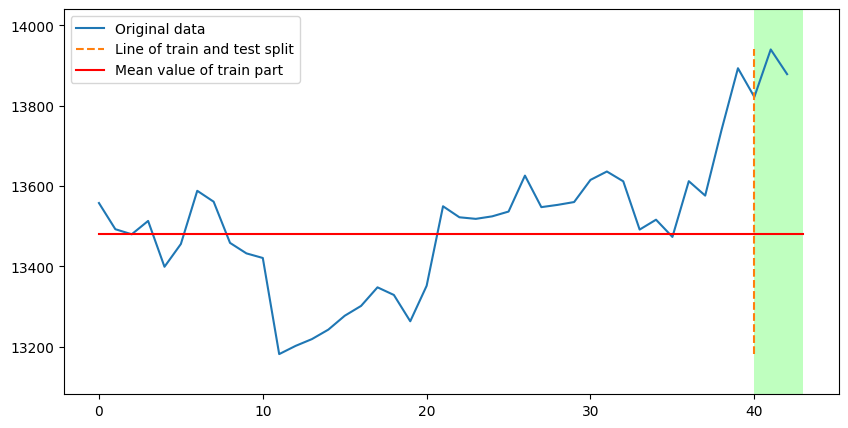

In [103]:
# Test and plot
b = next(iter(train_dataloader))

x, y, example_klines = b[0][:, 0].view(-1, 1), b[1][:, 0].view(-1, 1), b[2][0]

pred = model(x, y)
pred_idx = pred.argmax(-1).view(-1)[1:-1].numpy()
y_list = y.view(-1)[1:-1].tolist()

print('TARGET:', y_list)
print('TARGET as string:', [VOCABULARY_DECODE[n] for n in y_list])
print('-------------')
print('PRED:', pred_idx)
print('PRED as string:', [VOCABULARY_DECODE[n] for n in pred_idx])
print("\n")

mean = np.mean(example_klines[:DATA_LEN])


fig, axs = plt.subplots(1, figsize=(10,5), frameon=False)

axs.set_ylim(example_klines.min()-100, example_klines.max()+100)
axs.plot(example_klines, label='Original data')
axs.plot([DATA_LEN, DATA_LEN], [example_klines.min(), example_klines.max()], '--', label='Line of train and test split')
axs.plot([0, DATA_LEN + TAIL_LEN], [mean, mean], c='r', label='Mean value of train part')

for i, l in enumerate(pred_idx):
    h = axs.get_ylim()[1] - axs.get_ylim()[0]
    # Create a Rectangle patch
    if l == 2:
        rect = patches.Rectangle((DATA_LEN+i, axs.get_ylim()[0]), 1, h, linewidth=0, facecolor=(1,0,0,0.25))
    elif l == 3:
        rect = patches.Rectangle((DATA_LEN+i, axs.get_ylim()[0]), 1, h, linewidth=0, facecolor=(0,1,0,0.25))
    elif l == 4:
        rect = patches.Rectangle((DATA_LEN+i, axs.get_ylim()[0]), 1, h, linewidth=0, facecolor=(1,1,0,0.25))
    
    # Add the patch to the Axes
    axs.add_patch(rect)
#axs.imshow(gradient_list, aspect='auto', cmap=gradient, extent=(0, len(mask), axs.get_ylim()[0], axs.get_ylim()[1]), alpha=0.25)
plt.legend()
plt.show()